In [1]:
                                         #EMAIL SPAM DETECTION USING NLP 
    ----------------------------------------------------------------------------------------------------------------------

!pip install tensorflow

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [22]:
data = pd.read_csv("C:/Users/manum/OneDrive/Desktop/spamtext.csv")

In [23]:
data

,CATEGORY,MESSAGE,FILE_NAME
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",00249.5f45607c1bffe89f60ba1ec9f878039a
1,1,ATTENTION: This is a MUST for ALL Computer Use...,00373.ebe8670ac56b04125c25100a36ab0510
2,1,This is a multi-part message in MIME format.\n...,00214.1367039e50dc6b7adb0f2aa8aba83216
3,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,00210.050ffd105bd4e006771ee63cabc59978
4,1,This is the bottom line. If you can GIVE AWAY...,00033.9babb58d9298daa2963d4f514193d7d6
...,...,...,...
5791,0,"I'm one of the 30,000 but it's not working ver...",00609.dd49926ce94a1ea328cce9b62825bc97
5792,0,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,00957.e0b56b117f3ec5f85e432a9d2a47801f
5793,0,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",01127.841233b48eceb74a825417d8d918abf8
5794,0,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",01178.5c977dff972cd6eef64d4173b90307f0


In [24]:
data.head()

,CATEGORY,MESSAGE,FILE_NAME
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",00249.5f45607c1bffe89f60ba1ec9f878039a
1,1,ATTENTION: This is a MUST for ALL Computer Use...,00373.ebe8670ac56b04125c25100a36ab0510
2,1,This is a multi-part message in MIME format.\n...,00214.1367039e50dc6b7adb0f2aa8aba83216
3,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,00210.050ffd105bd4e006771ee63cabc59978
4,1,This is the bottom line. If you can GIVE AWAY...,00033.9babb58d9298daa2963d4f514193d7d6


In [25]:
data.shape

(5796, 3)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5796 entries, 0 to 5795
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   CATEGORY   5796 non-null   int64 
 1   MESSAGE    5796 non-null   object
 2   FILE_NAME  5796 non-null   object
dtypes: int64(1), object(2)
memory usage: 136.0+ KB


In [27]:
def get_sequences(texts,tokenizer,train=True,max_seq_length=None,):
    sequences=tokenizer.texts_to_sequences(texts)
    if train==True:
        max_seq_length=np.max(list(map(lambda x:len(x),sequences)))
    sequences=tf.keras.preprocessing.sequence.pad_sequences(sequences,maxlen=max_seq_length,padding='post')
    return sequences


In [28]:
def preprocess_inputs(df):
    df=df.copy()
    df=df.drop('FILE_NAME',axis=1)
    x=df['MESSAGE']
    y=df['CATEGORY']
    
    X_train,X_test,y_train,y_test=train_test_split(x,y,train_size=0.7,random_state=1,shuffle=True)
    #creating tokenizer
    tokenizer=tf.keras.preprocessing.text.Tokenizer(num_words=30000)
    #fit tokenizer
    tokenizer.fit_on_texts(X_train)
    
    #convert text in to sequences
    X_train=get_sequences(X_train,tokenizer,train=True)
    X_test=get_sequences(X_test,tokenizer,train=False,max_seq_length=X_train.shape[1])
    return X_train,X_test,y_train,y_test

In [29]:
X_train,X_test,y_train,y_test=preprocess_inputs(data)

In [30]:
X_train

array([[   14,   135,   188, ...,     0,     0,     0],
       [  183,  1452,  2119, ...,     0,     0,     0],
       [   56,   129,    20, ...,     0,     0,     0],
       ...,
       [  309,    12,    32, ...,     0,     0,     0],
       [   56,   179,   298, ...,     0,     0,     0],
       [   94,  4671, 11648, ...,     0,     0,     0]])

In [31]:
y_train.value_counts()

0    2738
1    1319
Name: CATEGORY, dtype: int64

In [32]:
X_train.shape

(4057, 14804)

In [33]:
inputs=tf.keras.Input(shape=(14804,))
embedding=tf.keras.layers.Embedding(input_dim=30000,output_dim=64)(inputs)
flatten=tf.keras.layers.Flatten()(embedding)
outputs=tf.keras.layers.Dense(1, activation='sigmoid')(flatten)

model=tf.keras.Model(inputs=inputs,outputs=outputs)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

print(model.summary())



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14804)]           0         
                                                                 
 embedding (Embedding)       (None, 14804, 64)         1920000   
                                                                 
 flatten (Flatten)           (None, 947456)            0         
                                                                 
 dense (Dense)               (None, 1)                 947457    
                                                                 
Total params: 2867457 (10.94 MB)
Trainable params: 2867457 (10.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [34]:
history=model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100


102/102 [==============================] - 10s 76ms/step - loss: 0.7076 - accuracy: 0.8080 - auc: 0.8110 - val_loss: 0.1144 - val_accuracy: 0.9766 - val_auc: 0.9971
Epoch 2/100
102/102 [==============================] - 7s 72ms/step - loss: 0.0543 - accuracy: 0.9855 - auc: 0.9995 - val_loss: 0.0446 - val_accuracy: 0.9877 - val_auc: 0.9989
Epoch 3/100
102/102 [==============================] - 7s 71ms/step - loss: 0.0156 - accuracy: 0.9982 - auc: 1.0000 - val_loss: 0.0337 - val_accuracy: 0.9865 - val_auc: 0.9991
Epoch 4/100
102/102 [==============================] - 7s 72ms/step - loss: 0.0077 - accuracy: 0.9991 - auc: 1.0000 - val_loss: 0.0311 - val_accuracy: 0.9889 - val_auc: 0.9992
Epoch 5/100
102/102 [==============================] - 7s 72ms/step - loss: 0.0047 - accuracy: 0.9994 - auc: 1.0000 - val_loss: 0.0310 - val_accuracy: 0.9889 - val_auc: 0.9991
Epoch 6/100
102/102 [==============================] - 7s 72ms/step - loss: 0.0034 - accuracy: 0.9994 - auc: 1.0000 -

In [35]:
results = model.evaluate(X_test, y_test, verbose=0)
results

[0.023458100855350494, 0.9930995106697083, 0.998832106590271]

In [36]:
print("    Test Loss: {:.4f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))
print("     Test AUC: {:.4f}".format(results[2]))

    Test Loss: 0.0235
Test Accuracy: 99.31%
     Test AUC: 0.9988


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns


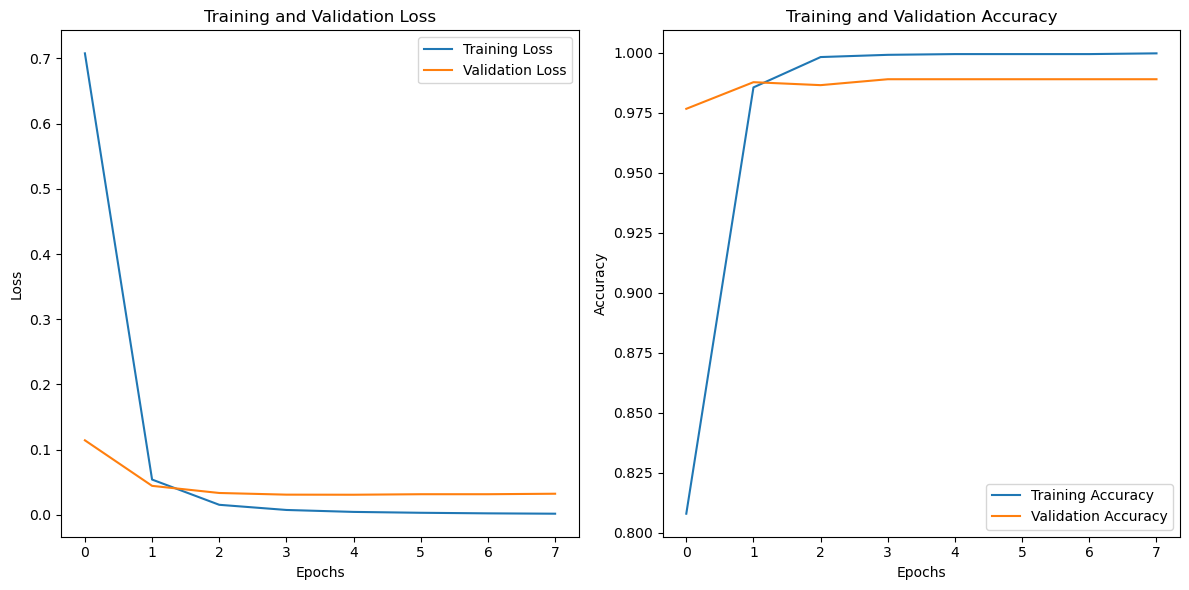

In [53]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()



plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()